## Gaining concentration from random quantum circuits

The question we are trying to address: Starting with poly(n)-sized random quantum circuits (RQC), how many additional gates do we need to get concentration on some bit string? We numerically address the question here by optimizing over paramitrized quantum circuits (PQC)

The objective function is:
$$\max_{{\pmb\theta}} |\langle{0^n|U_{rqc}U_{pqc}(\pmb\theta)}|{0^n}\rangle|^2. $$

We first start from generating a depth-n random circuit with brickwall structure, acted on the all-zero state:

In [1]:
from circuits import*

n = 12 # system size
depth = n # circuit depth
rqc = qmps_f(n, in_depth=depth, n_Qbit=n-1, qmps_structure="brickwall",)


We could also draw the circuit as a tensornetwork, the arrow indicates the direction of computation:

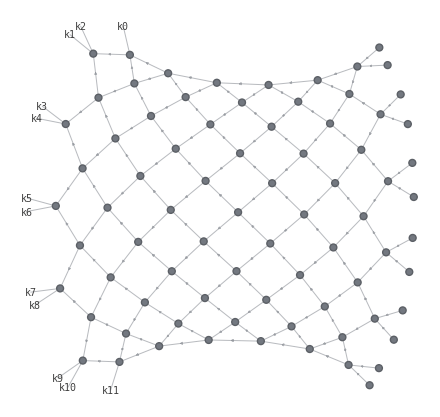

In [2]:
rqc.draw()

Then define a PQC with half of the RQC depth:

In [3]:
pqc = qmps_f(n, in_depth=depth//2, n_Qbit=n-1, qmps_structure="brickwall",)

optmzr = TNOptimizer(
    pqc,                                # our initial input, the tensors of which to optimize
    loss_fn=negative_overlap,
    norm_fn=norm_f,
    loss_target=-1+1e-2,
    constant_tags=['MPS'],
    loss_constants={'target': rqc},  # this is a constant TN to supply to loss_fn
    autodiff_backend='tensorflow',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='L-BFGS-B',               # supplied to scipy.minimize
)
mps_opt = optmzr.optimize(500,tol = 1e-10,)  # perform ~100 gradient descent steps'''

-0.363060408952 [best: -0.363060408952] : : 558it [06:16,  1.48it/s]                       


Compare this with the average peak weight from depth n/2 RQC (averaged over 100 events):

In [5]:
average_peak_weight(n,depth = n//2, shots=100)[0]
# returns: np.mean(peak), np.std(peak)/np.sqrt(shots), np.max(peak) where peak is the list of the 100 'peaks'

(0.005950453401162744, 0.00020977040532438418, 0.014530881813522014)

This means, by optimizing the PQC, we are gaining much better concentration compared with trivially inverting the last n/2 layers. 

Meanwhile we could also examine the individual gates from the optimized PQC:

In [12]:
U = pqc.tensors[13].data.reshape(4,4)
#Check unitarity:
(U@np.conj(U.T)).round(10)

array([[ 1.+0.j,  0.-0.j, -0.-0.j,  0.-0.j],
       [ 0.+0.j,  1.+0.j,  0.-0.j,  0.-0.j],
       [-0.+0.j,  0.+0.j,  1.+0.j,  0.-0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]])

In [16]:
print(U.round(4))

[[-0.5666+0.0359j -0.0531+0.1163j -0.4808+0.5028j -0.386 -0.1682j]
 [-0.4044-0.1474j  0.568 -0.3259j  0.4541-0.1081j -0.134 -0.3874j]
 [-0.113 +0.2215j -0.6008+0.0508j  0.3437+0.1113j  0.2674-0.6105j]
 [ 0.1758+0.6322j  0.4373-0.0136j -0.4051-0.0592j  0.3109-0.3373j]]
